[*********************100%***********************]  1 of 1 completed


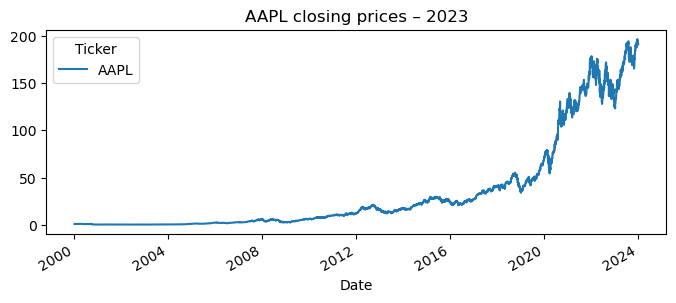

In [4]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

ticker = "AAPL"
prices = yf.download(ticker, start="2000-01-01", end="2023-12-31")["Close"].dropna()
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()


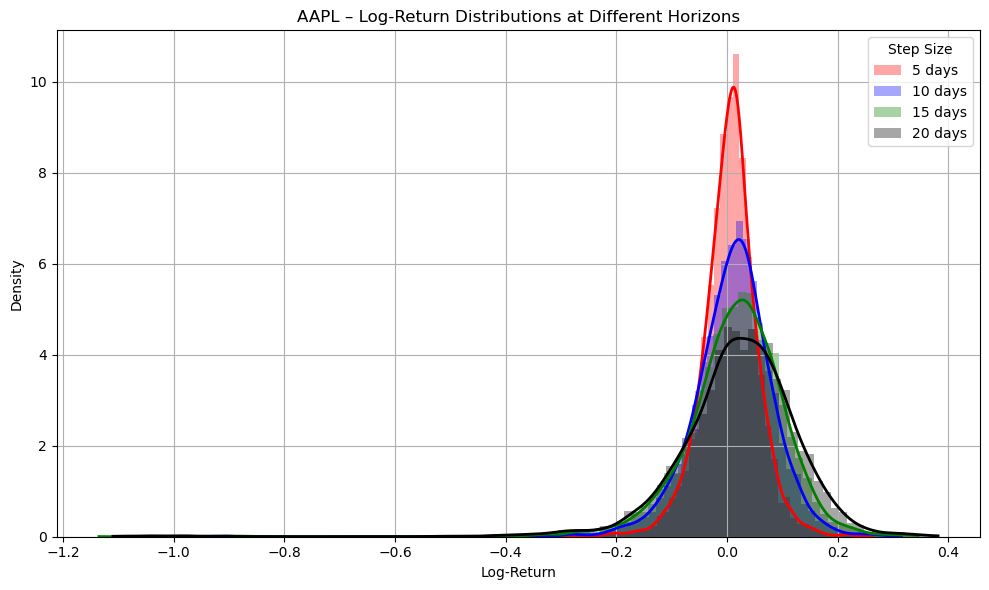

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

two_week_steps_list = [5, 10, 15, 20]  # trading-day lags
colors = ["red", "blue", "green", "black"]

plt.figure(figsize=(10, 6))

for i, step in enumerate(two_week_steps_list):
    # Compute log-returns at the given step size
    log_returns = np.log(prices / prices.shift(step)).dropna().values
    
    # Plot histogram (density normalized)
    plt.hist(
        log_returns,
        bins=100,
        density=True,
        color=colors[i],
        alpha=0.35,
        label=f"{step} days",
        edgecolor='none'
    )
    
    # Calculate KDE using scipy with correct shape
    kde = gaussian_kde(log_returns.reshape(1, -1))
    x_vals = np.linspace(log_returns.min(), log_returns.max(), 1000)
    plt.plot(x_vals, kde(x_vals), color=colors[i], linewidth=2)

plt.title(f"{ticker} – Log-Return Distributions at Different Horizons")
plt.xlabel("Log-Return")
plt.ylabel("Density")
plt.legend(title="Step Size")
plt.grid(True)
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...


2768 daily log-returns from 2013-01-02 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/cloud/miniconda3/envs/math-finance/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


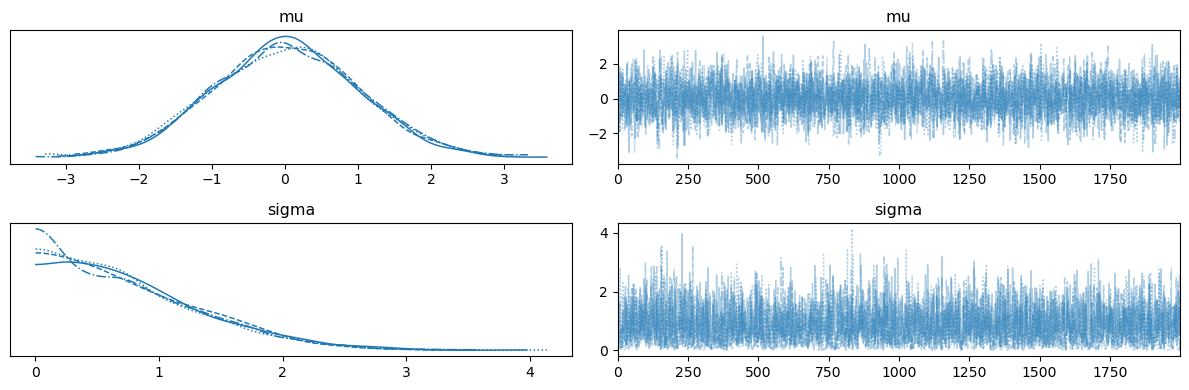

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0217,1.0065,-1.8095,1.9654,0.0170,0.0132,3520.6381,3304.5624,1.0005
sigma,0.7948,0.6071,0.0001,1.8844,0.0102,0.0068,2486.2405,2013.1332,1.0015


In [17]:
# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returnsgit 
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2000,
        tune          = 2000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


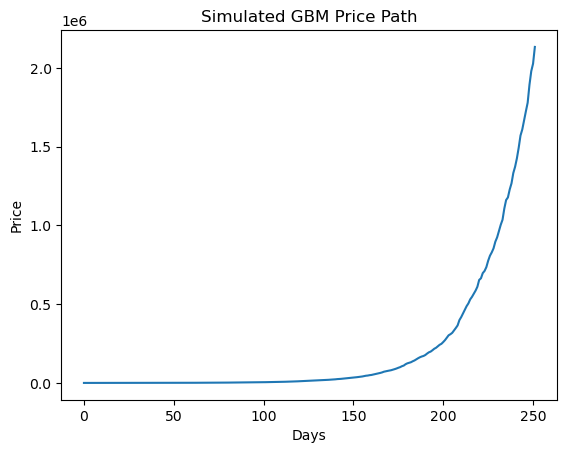

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


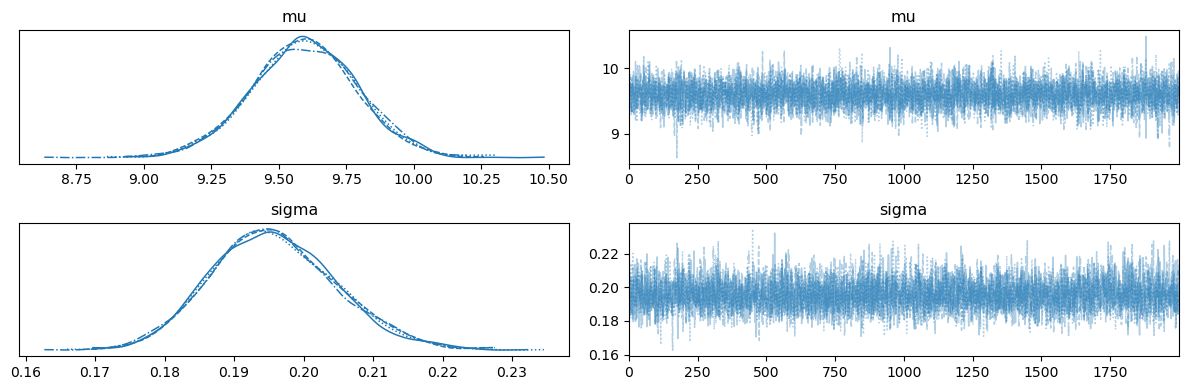


Posterior Summary:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     9.5958  0.1958  9.2284   9.9706     0.0027   0.0023  5447.0938   
sigma  0.1957  0.0090  0.1798   0.2133     0.0001   0.0001  4286.8528   

        ess_tail   r_hat  
mu     5182.1188  1.0001  
sigma  4223.4995  1.0011  

True mu = 10, True sigma = 0.2


In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# --- Step 1: Simulate GBM path ---
np.random.seed(42)

T = 1.0        # 1 year
N = 252        # trading days
dt = T / N
mu_true = 10  # 10% drift
sigma_true = 0.2  # 20% annual volatility

# Simulate log-returns
log_returns_sim = (mu_true - 0.5 * sigma_true**2) * dt + sigma_true * np.sqrt(dt) * np.random.randn(N)
# Simulated price path
S0 = 100
prices_sim = S0 * np.exp(np.cumsum(log_returns_sim))

plt.plot(prices_sim)
plt.title("Simulated GBM Price Path")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

# --- Step 2: Inference from log-returns (like in real case) ---
with pm.Model() as model_sim:
    mu = pm.Normal("mu", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    pm.Normal(
        "returns",
        mu=mu * dt,
        sigma=sigma * np.sqrt(dt),
        observed=log_returns_sim
    )

    trace_sim = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )

# --- Step 3: Results ---
az.plot_trace(trace_sim, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

print("\nPosterior Summary:")
print(az.summary(trace_sim, var_names=["mu", "sigma"], round_to=4))
print(f"\nTrue mu = {mu_true}, True sigma = {sigma_true}")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/cloud/miniconda3/envs/math-finance/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


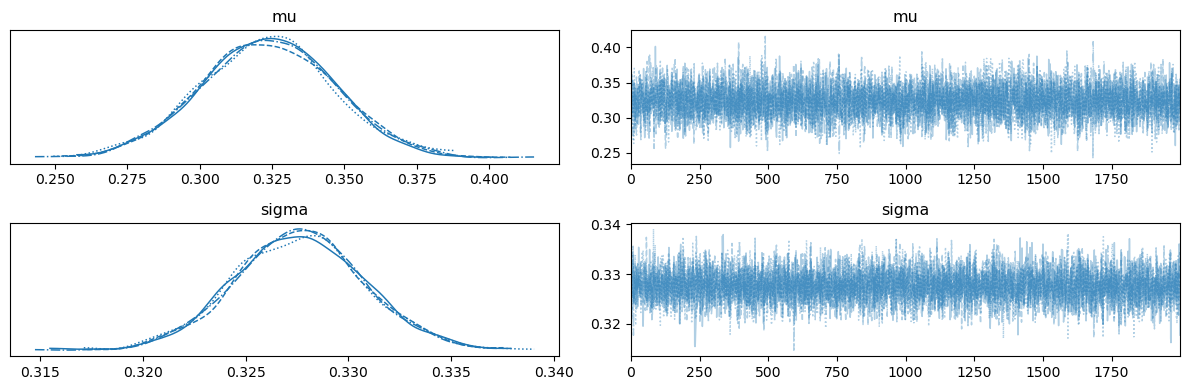

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.3234,0.0229,0.2785,0.3655,0.0003,0.0003,5808.9031,4872.9548,1.0001
sigma,0.3276,0.0031,0.3217,0.3336,0.0000,0.0000,5747.0215,5041.8039,1.0004


In [11]:
# --- 3. Transform to log-returns (the GBM observation) ---------------------

# dt = 1/26                                                # one trading day expressed in years
dt = 1/252


# Number of trading days in two weeks (approx 10; adjust if needed)
two_week_steps = 10
dt = two_week_steps/252

# Compute biweekly log-returns: r_t = ln(S_{t}/S_{t-10})
biweek_log_returns = np.log(prices / prices.shift(two_week_steps)).dropna().values

# print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
    #   f"to {prices.index[-1].date()}")

with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=10)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=10)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = biweek_log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2000,
        tune          = 2000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


In [ ]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, T, r, option_type='call'):
    def difference(sigma):
        bs_price = black_scholes_price(S, K, T, r, sigma, option_type)
        return bs_price - market_price

    result = brentq(difference, 1e-6, 5)
    return result

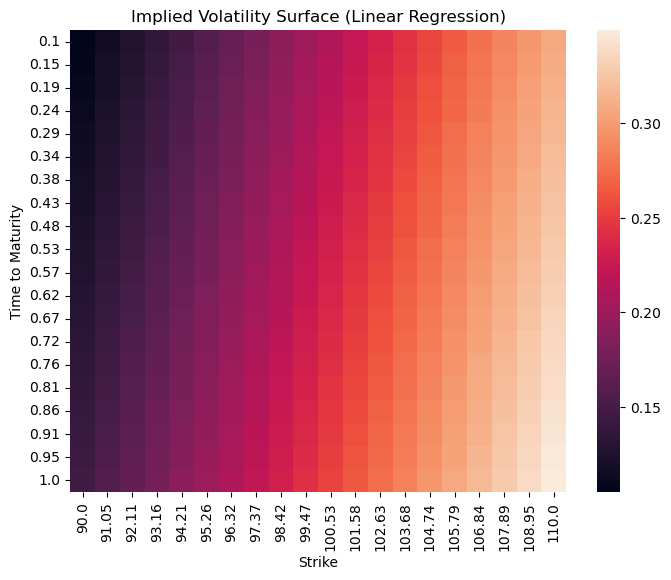

In [9]:
# Dummy data (replace with real market data)
np.random.seed(0)
K = np.linspace(90, 110, 20)
T = np.linspace(0.1, 1.0, 20)
K_grid, T_grid = np.meshgrid(K, T)
IV = 0.2 + 0.01 * (K_grid - 100) + 0.05 * T_grid + np.random.normal(0, 0.01, size=K_grid.shape)

X = np.column_stack([K_grid.ravel(), T_grid.ravel()])
y = IV.ravel()

reg = LinearRegression().fit(X, y)
IV_pred = reg.predict(X).reshape(K_grid.shape)

# Plot surface
plt.figure(figsize=(8,6))
sns.heatmap(IV_pred, xticklabels=np.round(K, 2), yticklabels=np.round(T, 2))
plt.title("Implied Volatility Surface (Linear Regression)")
plt.xlabel("Strike")
plt.ylabel("Time to Maturity")
plt.show()


In [11]:
import pymc as pm
import arviz as az

# Simulated option data
S = 100
K = 100
T = 0.5
r_true = 0.01
sigma_true = 0.2
observed_price = black_scholes_price(S, K, T, r_true, sigma_true)

with pm.Model() as model:
    sigma = pm.Uniform("sigma", 0.01, 1.0)
    r = pm.Uniform("r", 0.0, 0.1)
    
    theoretical_price = black_scholes_price(S, K, T, r, sigma)
    
    obs = pm.Normal("obs", mu=theoretical_price, sigma=1.0, observed=observed_price)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["sigma", "r"])
plt.show()


TypeError: TensorVariable cannot be converted to Python boolean. Call `.astype(bool)` for the symbolic equivalent.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


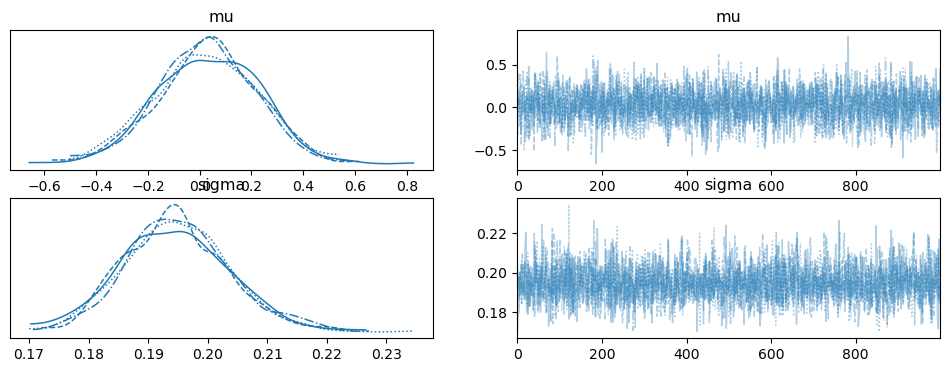

In [12]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Simulate GBM data (you can later replace this with real stock prices)
np.random.seed(42)
T = 1.0  # total time in years
N = 252  # number of time steps (e.g., trading days)
dt = T / N
mu_true = 0.05
sigma_true = 0.2

S0 = 100
returns = np.random.normal(mu_true * dt, sigma_true * np.sqrt(dt), size=N)
S = S0 * np.exp(np.cumsum(returns))

log_returns = np.diff(np.log(S))

# Bayesian Inference
with pm.Model() as gbm_model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    likelihood = pm.Normal("returns", mu=mu * dt, sigma=sigma * np.sqrt(dt), observed=log_returns)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["mu", "sigma"])
plt.show()


[*********************100%***********************]  1 of 1 completed


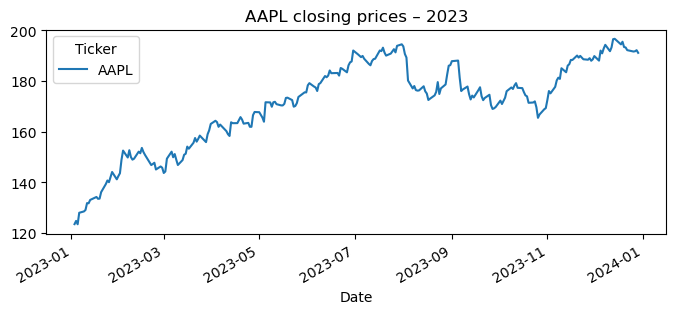

Initializing NUTS using jitter+adapt_diag...


250 daily log-returns from 2023-01-03 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


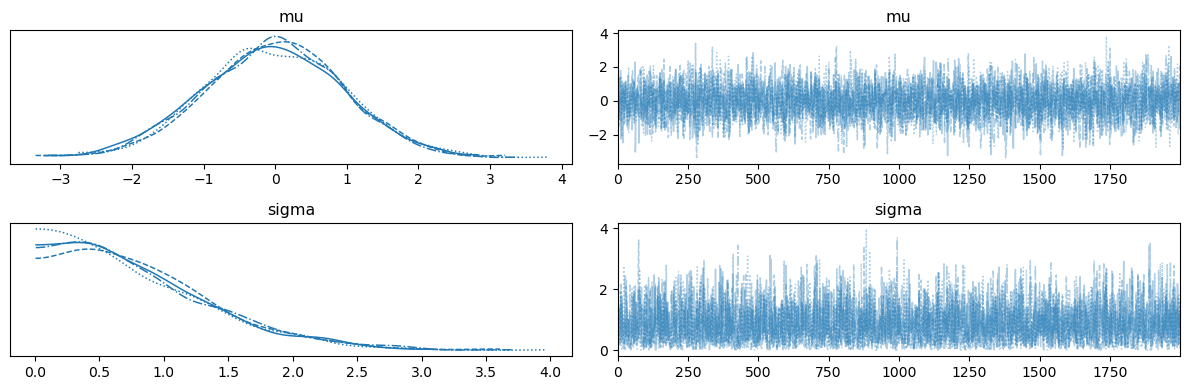

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.0197,0.9786,-1.8322,1.8461,0.0163,0.0126,3596.2035,3921.0559,1.0004
sigma,0.8047,0.5982,0.0001,1.9017,0.0096,0.0074,2794.7859,2320.6417,1.0025


In [13]:
# --- 1. Imports -------------------------------------------------------------
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --- 2. Download daily closes for 2023 -------------------------------------
ticker = "AAPL"
prices = (
    yf.download(ticker, start="2023-01-01", end="2023-12-31")  # daily bars
      ["Close"]                                                # keep only Close column
      .dropna()
)
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()

# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252                                                # one trading day expressed in years

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

# --- 4. Bayesian inference with PyMC ---------------------------------------
with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1.0)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1.0)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2_000,
        tune          = 2_000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


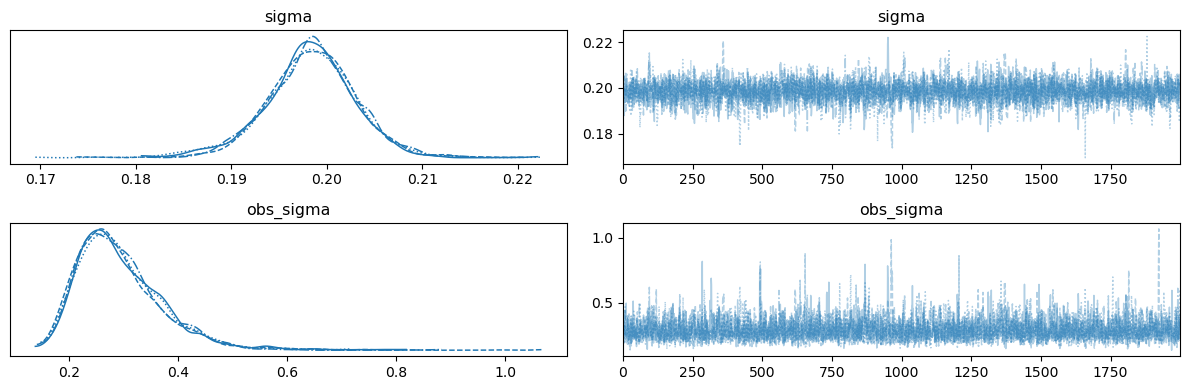

         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma  0.1984  0.0047  0.1894   0.2073     0.0001   0.0001  3657.361   

        ess_tail   r_hat  
sigma  2986.4756  1.0007  


In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ---------- market data (real or synthetic) ----------
S  = 100.0                    # spot
r  = 0.01                     # risk-free rate
T  = 0.5                      # time to maturity (yrs)
K  = np.linspace(80, 120, 10) # strikes
true_sigma = 0.20

from scipy.stats import norm
def bs_call_price_np(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

C_obs = bs_call_price_np(S, K, T, r, true_sigma)
C_obs += np.random.normal(0, 0.25, size=K.shape)

# ---------- Bayesian calibration ----------
with pm.Model() as model:

    K_data = pm.ConstantData("K_data", K)
    
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    obs_sigma = pm.HalfNormal("obs_sigma", sigma=0.5)
    
    def Phi(x):
        return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))
    
    # Black-Scholes call price computed symbolically
    d1 = (pm.math.log(S / K_data) + (r + 0.5 * sigma**2) * T) / (sigma * pm.math.sqrt(T))
    d2 = d1 - sigma * pm.math.sqrt(T)
    C_model = S * Phi(d1) - K_data * pm.math.exp(-r * T) * Phi(d2)
    
    # observation noise (learn it or fix it)

    pm.Normal("C_obs", mu=C_model, sigma=obs_sigma, observed=C_obs)
    
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.95, return_inferencedata=True)

# ---------- diagnostics ----------
az.plot_trace(trace)
plt.tight_layout(); plt.show()

print(az.summary(trace, var_names=["sigma"], round_to=4))
